<a href="https://colab.research.google.com/github/nqa112/MandevicesLab-AI/blob/main/DogCatClassification_VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!nvidia-smi -L

GPU 0: Tesla K80 (UUID: GPU-c83b84c0-c745-9360-6367-d40600c62986)


In [2]:
import os
import random
import pandas as pd
import shutil
from tensorflow import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten, Dropout, BatchNormalization, Activation
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [3]:
# Download dataset from Kaggle, creating API on Kaggle is needed
!pip install -q kaggle
!pip install -q kaggle-cli
!mkdir -p ~/.kaggle
!cp "/content/drive/MyDrive/AI/kaggle.json" ~/.kaggle/
!cat ~/.kaggle/kaggle.json 
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d biaiscience/dogs-vs-cats -p '/content'

     |████████████████████████████████| 74 kB 2.0 MB/s 
     |████████████████████████████████| 4.2 MB 29.8 MB/s 
     |████████████████████████████████| 112 kB 60.6 MB/s 
     |████████████████████████████████| 49 kB 5.7 MB/s 
     |████████████████████████████████| 149 kB 68.7 MB/s 
  ERROR: Failed building wheel for lxml
    Running setup.py install for lxml ... error
ERROR: Command errored out with exit status 1: /usr/bin/python3 -u -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-lvwrlivd/lxml_3fb4565a36d24a309909e12189acc70f/setup.py'"'"'; __file__='"'"'/tmp/pip-install-lvwrlivd/lxml_3fb4565a36d24a309909e12189acc70f/setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' install --record /tmp/pip-record-y96kpka4/install-record.txt --s

In [4]:
!unzip -q '/content/dogs-vs-cats.zip' -d '/content'

In [ ]:
# Check PIL unidentified images to avoid error while training
from PIL import Image
folder_path = '/content/train/train'  # Write the folder where your picture is located, that is, the folder containing the image
extensions = []
for filee in os.listdir(folder_path):
    file_path = os.path.join(folder_path, filee)
    print('** Path: {}  **'.format(file_path), end="\r", flush=True)
    im = Image.open(file_path)
    rgb_im = im.convert('RGB')
    if filee.split('.')[1] not in extensions:
        extensions.append(filee.split('.')[1])

In [ ]:
# Delete unidentified images
path = ''
if os.path.exists(path):
  os.remove(path)
else:
  print("The file does not exist")

In [17]:
# Split cat and dog images to folders respectively
src = '/content/train/train' #folder containing both dogs and cats
classes = ['dog', 'cat']

# create new folder with corresponding class
for chr in classes:
  des = os.path.join(src,chr.upper()) 
  os.makedirs(des)

  # move images from source folder to corresponding class folder
  for f in os.listdir(src):
      if chr in f:
        shutil.move(os.path.join(src,f), os.path.join(des,f))
      else:
        continue 

In [ ]:
!ls /content/train/train # Check files and sub folders

CAT  DOG


In [18]:
# Split train and validation from original train folder
val_split = 0.2
trainPath = '/content/train/train'
os.mkdir('/content/val')

for c in os.listdir(trainPath):
  trainSub = os.path.join(trainPath, c)
  os.mkdir(f'/content/val/{c}')
  valNum = int(len(os.listdir(trainSub)) * val_split)

  for i in range(valNum):
    imgName = random.choice(os.listdir(trainSub))
    shutil.move(os.path.join(trainSub, imgName), os.path.join(f'/content/val/{c}', imgName))

In [45]:
# Check the number of images in train and test folder
# Validation images will be created by flow_from_directory trick
numTrain_dog = len(os.listdir('/content/train/train/DOG'))
numTrain_cat = len(os.listdir('/content/train/train/CAT'))
numVal_dog = len(os.listdir('/content/val/DOG'))
numVal_cat = len(os.listdir('/content/val/CAT'))
numTest = len(os.listdir('/content/test/test'))

print(f'Use {numTrain_cat + numTrain_dog} images for training.\n')
print(f'Use {numVal_cat + numVal_dog} images for validating.\n')
print(f'Use {numTest} images for testing')

Use 20000 images for training
Use 5000 images for validating
Use 12500 images for testing


In [46]:
# Set up some variables
image_size = (224,224)
batch_size = 32
epoch = 50

In [47]:
# Generate train and validation batches with augmentation
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range=30,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest'
                                   )

test_datagen = ImageDataGenerator(rescale = 1./255)

trainData = train_datagen.flow_from_directory('/content/train/train',
                                                target_size = image_size,
                                                batch_size = batch_size,
                                                shuffle = True,
                                                class_mode = "categorical",
                                                )

valData = test_datagen.flow_from_directory('/content/val',
                                            target_size = image_size,
                                            batch_size = batch_size,
                                            shuffle = True,
                                            class_mode = "categorical",
                                            )
trainData.class_indices # Dictionary containing the mapping from class names to class indices

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


{'CAT': 0, 'DOG': 1}

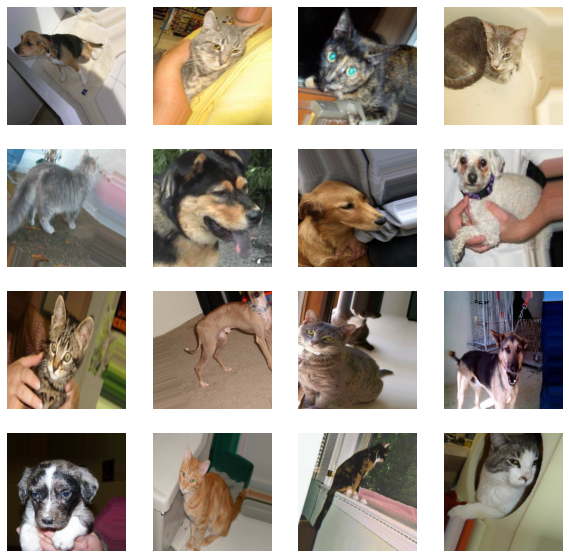

In [ ]:
# Visualize generated data
fig = plt.figure(figsize=(10,10))
columns = 4
rows = 4
for i in range(1, columns*rows +1):
    img, label = trainData.next()
    fig.add_subplot(rows, columns, i)
    plt.imshow(img[0].astype('float32'))
    plt.axis('off')
plt.show()

In [31]:
#build VGG-16 from scratch
model =Sequential()

model.add(Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding="same"))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same"))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same"))
model.add(Activation('relu'))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same"))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same"))
model.add(Activation('relu'))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same"))
model.add(Activation('relu'))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same"))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same"))
model.add(Activation('relu'))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same"))
model.add(Activation('relu'))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same"))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same"))
model.add(Activation('relu'))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same"))
model.add(Activation('relu'))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same"))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(units=4096))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(units=4096))
model.add(Activation('relu'))
model.add(Dense(units=2, activation="softmax"))

In [32]:
from tensorflow.keras.optimizers import Adam
opt = Adam(learning_rate=1e-5)
model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"])

In [33]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 64)     256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 224, 224, 64)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 activation_1 (Activation)   (None, 224, 224, 64)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                      

In [52]:
"""Callback to plot the learning curves of the model during training."""
class PlotLearning(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []
            

    def on_epoch_end(self, epoch, logs={}):
        # Storing metrics
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]
        
        # Plotting
        metrics = [x for x in logs if 'val' not in x]
        
        f, axs = plt.subplots(1, len(metrics), figsize=(15,5))
        clear_output(wait=True)

        for i, metric in enumerate(metrics):
            axs[i].plot(range(1, epoch + 2), 
                        self.metrics[metric], 
                        label=metric)
            if logs['val_' + metric]:
                axs[i].plot(range(1, epoch + 2), 
                            self.metrics['val_' + metric], 
                            label='val_' + metric)
                
            axs[i].legend()
            axs[i].grid()

        plt.tight_layout()
        plt.show()

In [53]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger
checkpoint = ModelCheckpoint("/content/drive/MyDrive/AI/vgg16_1.h5", 
                             monitor='val_loss', verbose=1, save_best_only=True, 
                             save_weights_only=False, 
                             mode='auto')

early = EarlyStopping(monitor='val_loss', 
                      min_delta=0, 
                      patience=10,
                      verbose=1, 
                      mode='auto')

log = CSVLogger('/content/drive/MyDrive/AI/training1.log', 
                separator=',', 
                append=True)

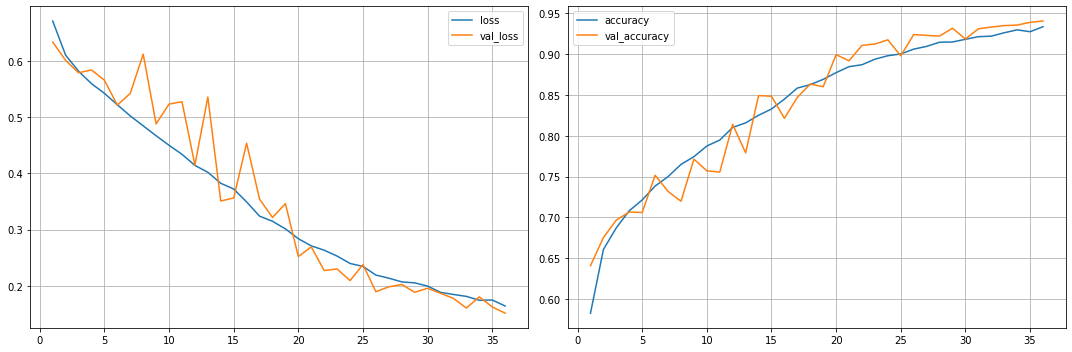

625/625 [==============================] - 619s 989ms/step - loss: 0.1641 - accuracy: 0.9335 - val_loss: 0.1513 - val_accuracy: 0.9405
Epoch 37/50
544/625 [=========================>....] - ETA: 1:12 - loss: 0.1667 - accuracy: 0.9316

In [ ]:
hist = model.fit(trainData, 
                 epochs = epoch,
                 steps_per_epoch= round(trainData.samples / batch_size), 
                 callbacks=[checkpoint,early,log, PlotLearning()], 
                 validation_data=valData,
                 validation_steps= round(valData.samples / batch_size))

**CONTINUE TRAINING FROM LOADED MODEL**



In [24]:
!gdown --id 17YtEaD_aWLq3o9zA-lvmRXtuUItcoU0B
!gdown --id 1-4ZURoNWVkP-6rc844yl_w0TnTraTczd

Downloading...
From: https://drive.google.com/uc?id=17YtEaD_aWLq3o9zA-lvmRXtuUItcoU0B
To: /content/vgg16_1.h5
100% 1.61G/1.61G [00:09<00:00, 178MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-4ZURoNWVkP-6rc844yl_w0TnTraTczd
To: /content/training1.log
100% 2.93k/2.93k [00:00<00:00, 2.22MB/s]


In [ ]:
import tensorflow.keras.models
new_model = tensorflow.keras.models.load_model('/content/drive/MyDrive/AI/vgg16_1.h5')

hist = new_model.fit(trainData, 
                 epochs = epoch,
                 steps_per_epoch= round(trainData.samples / batch_size), 
                 callbacks=[checkpoint,early,log, PlotLearning()], 
                 validation_data=valData,
                 validation_steps= round(valData.samples / batch_size))

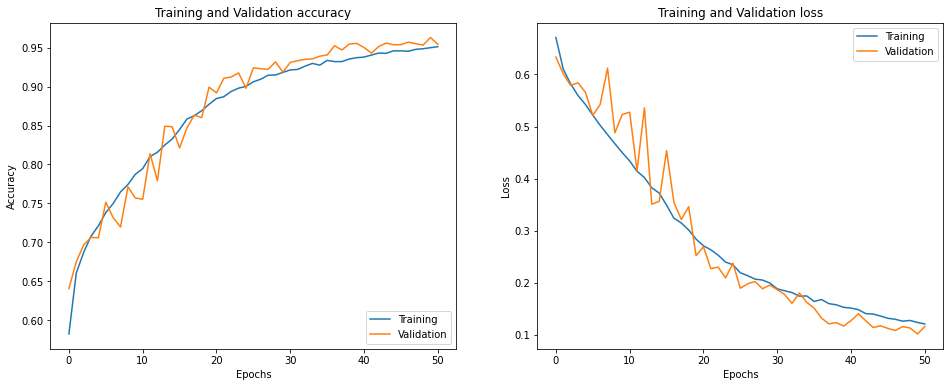

In [24]:
# You can also visualize model training process with csv .log file, which was saved during training
df = pd.read_csv('/content/drive/MyDrive/AI/training1.log')

acc = df[['accuracy']]
val_acc = df[['val_accuracy']]

loss = df[['loss']]
val_loss = df[['val_loss']]

epochs_range = df[['epoch']]

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training')
plt.plot(epochs_range, val_acc, label='Validation')
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend(loc='lower right')
plt.title('Training and Validation accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training')
plt.plot(epochs_range, val_loss, label='Validation')
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend(loc='upper right')
plt.title('Training and Validation loss')
plt.show()

In [18]:
# input must equal to input shape of VGG-16
image_size = (224,224)
saved_model = load_model("/content/drive/MyDrive/AI/vgg16_1.h5")

Predict 100.0% dog



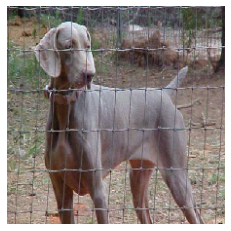

In [43]:
# Image prediction
img = image.load_img("/content/test/test/3945.jpg", target_size=image_size)
plt.imshow(img)
plt.axis('off')
img = np.expand_dims(img, axis=0)
output = saved_model.predict(img)

if np.argmax(output) == 0:
    print(f"Predict {output[0][0] * 100}% cat\n")
else:
    print(f"Predict {output[0][1] * 100}% dog\n")